In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/CV_PA3"

/content/drive/MyDrive/CV_PA3


In [ ]:
!pip install pytorch_lightning segmentation_models_pytorch==0.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 40.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=64a50ef3aa4e4267c43861dc2bd13fa342c38a8ca06659f8fc0da0c570697082
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=4d57508d861466ff46df1378dddf2703b2cddef4fa669d59ba03a7a5c7b904c0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/

In [ ]:
import os
import copy

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from torch.utils.data import DataLoader

import cv2

from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from pytorch_lightning import LightningDataModule
from pytorch_lightning.callbacks import LearningRateMonitor, RichProgressBar, ModelCheckpoint, RichModelSummary

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

def cal_iou(logits_mask, mask):
    prob_mask = logits_mask.sigmoid()
    pred_mask = (prob_mask > 0.5).float()
    tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

    per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
    dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

    #print(f'per_image_iou: {per_image_iou}, dataset_iou: {dataset_iou}')
    return per_image_iou, dataset_iou


dataset_config = {
    "root": "./dataset",
    "train_batch_size": 8,
    "valid_batch_size": 1,
}

simple_unet_config = {
    "model": {
        "encoder_name"   : "resnet34",
        "encoder_depth"  : 5,
        "encoder_weights": None,
        "in_channels"    : 3,
        "classes"        : 1,

    },
    "train": {
        "epoch": 2,
        "lr"   : 0.001,
    }
}

cspn_unet_config = {
    "model": {
        "encoder_name"   : "resnet34",
        "encoder_depth"  : 5,
        "encoder_weights": None,
        "in_channels"    : 4,
        "classes"        : 8,

    },
    "train": {
        "epoch": 40,
        "lr"   : 0.001,
    }
}

In [ ]:
# 0. Download the Dataset
class PA3_DataModule(LightningDataModule):
    def __init__(
            self,
            root="./dataset",
            train_batch_size=8,
            valid_batch_size=1,
            num_workers=None
        ):
        super().__init__()
        self.root = root
        self.train_batch_size = train_batch_size
        self.valid_batch_size = valid_batch_size
        self.num_workers = num_workers if num_workers is not None else os.cpu_count()

        try:
          self.train_dataset = SimpleOxfordPetDataset(self.root, "train")
          self.valid_dataset = SimpleOxfordPetDataset(self.root, "valid")
        except:
          print("There is no dataset. Download...")

          SimpleOxfordPetDataset.download(self.root)
          self.train_dataset = SimpleOxfordPetDataset(self.root, "train")
          self.valid_dataset = SimpleOxfordPetDataset(self.root, "valid")

    def print_len(self):
        print(f"Train Dataset Size: {len(self.train_dataset)}")
        print(f"Valid Dataset size: {len(self.valid_dataset)}")

    def train_dataloader(self):
        return DataLoader(
                  self.train_dataset,
                  batch_size=self.train_batch_size,
                  shuffle=True,
                  num_workers=self.num_workers
              )
    def val_dataloader(self):
        return DataLoader(
                  self.valid_dataset,
                  batch_size=self.valid_batch_size,
                  shuffle=False,
                  num_workers=self.num_workers
              )

pa3_datamodule = PA3_DataModule(
    root=dataset_config["root"],
    train_batch_size=dataset_config["train_batch_size"],
    valid_batch_size=dataset_config["valid_batch_size"],
)
pa3_datamodule.print_len()

train_dataloader = pa3_datamodule.train_dataloader()
valid_dataloader = pa3_datamodule.val_dataloader()

Train Dataset Size: 3312
Valid Dataset size: 368


In [ ]:
# 1. Implementation of any Unet (coarse segmentation)

# 1.1. Load the Unet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_config = simple_unet_config["model"]
simple_unet = smp.Unet(
                  encoder_name    = model_config["encoder_name"],
                  encoder_weights = model_config["encoder_weights"],
                  in_channels     = model_config["in_channels"],
                  classes         = model_config["classes"],
                ).to(device)

# 1.2. Train
train_config = simple_unet_config["train"]
num_epochs = train_config["epoch"]
optimizer = optim.AdamW(simple_unet.parameters(), lr = train_config["lr"])
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

do_simple_unet_train = True
if do_simple_unet_train:
  for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}/{num_epochs}")
      # Train
      simple_unet.train()
      train_loss = 0.0
      train_per_image_iou = 0.0
      train_dataset_iou = 0.0
      for train_images in tqdm(train_dataloader, leave=True):
          # Load Batch Data
          image, mask = train_images["image"], train_images["mask"]
          image, mask = image.float(), mask.float()
          image, mask = image.to(device), mask.to(device)

          # Init Optimizer
          optimizer.zero_grad()

          # Foward
          outputs_mask = simple_unet(image)

          # Backward
          loss = criterion(outputs_mask, mask)
          loss.backward()

          # Sum Train loss
          train_loss += loss.item() * image.size(0)

          # Calculate IOU
          per_image_iou, dataset_iou = cal_iou(outputs_mask, mask)
          train_per_image_iou += per_image_iou
          train_dataset_iou += dataset_iou

          # Update
          optimizer.step()

      # Log one epoch
      train_len = len(train_dataloader)
      train_loss /= train_len
      train_per_image_iou /= train_len
      train_dataset_iou /= train_len
      print(f"Train Loss: {train_loss:.4f}, Train Per Image IOU: {train_per_image_iou:.4f}, Train Dataset IOU: {train_dataset_iou:.4f}")

      # Validation
      simple_unet.eval()
      valid_loss = 0.0
      valid_per_image_iou = 0.0
      valid_dataset_iou = 0.0
      with torch.no_grad():
          for valid_images in tqdm(valid_dataloader, leave=True):
              # Load Batch Data
              image, mask = valid_images["image"], valid_images["mask"]
              image, mask = image.float(), mask.float()
              image, mask = image.to(device), mask.to(device)

              # Prediction
              outputs_mask = simple_unet(image)
              cal_iou(outputs_mask, mask)

              # Loss
              loss = criterion(outputs_mask, mask)

              # Sum Valid loss
              valid_loss += loss.item() * image.size(0)

              # Calculate IOU
              per_image_iou, dataset_iou = cal_iou(outputs_mask, mask)
              valid_per_image_iou += per_image_iou
              valid_dataset_iou += dataset_iou

      # Log one epoch
      valid_len = len(valid_dataloader)
      valid_loss /= valid_len
      valid_per_image_iou /= valid_len
      valid_dataset_iou /= valid_len
      print(f"Valid Loss: {valid_loss:.4f}, Valid Per Image IOU: {valid_per_image_iou:.4f}, Valid Dataset IOU: {valid_dataset_iou:.4f}")

  # Save model
  torch.save(simple_unet.state_dict(), "simple_unet.pth")

Epoch 1/2


100%|██████████| 414/414 [00:16<00:00, 24.38it/s]


Train Loss: 2.0328, Train Per Image IOU: 0.6045, Train Dataset IOU: 0.6060


100%|██████████| 368/368 [00:05<00:00, 66.69it/s]


Valid Loss: 0.3743, Valid Per Image IOU: 0.4841, Valid Dataset IOU: 0.4841
Epoch 2/2


100%|██████████| 414/414 [00:17<00:00, 24.03it/s]


Train Loss: 1.6466, Train Per Image IOU: 0.6608, Train Dataset IOU: 0.6612


100%|██████████| 368/368 [00:05<00:00, 69.11it/s]


Valid Loss: 0.2426, Valid Per Image IOU: 0.6252, Valid Dataset IOU: 0.6252


(-0.5, 255.5, 255.5, -0.5)

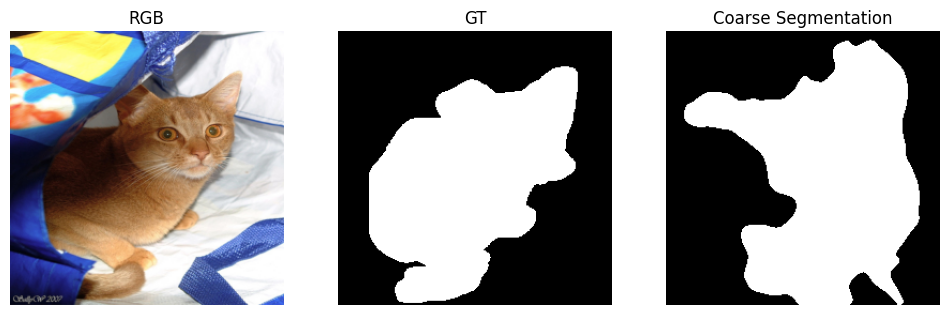

In [ ]:
# 1.3. Test simple unet using sample dataset

# Load Train Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_config = simple_unet_config["model"]
simple_unet = smp.Unet(
                  encoder_name    = model_config["encoder_name"],
                  encoder_weights = model_config["encoder_weights"],
                  in_channels     = model_config["in_channels"],
                  classes         = model_config["classes"],
                ).to(device)
simple_unet.load_state_dict(torch.load("simple_unet.pth", map_location=device))

simple_unet.eval()

# Load Sample Data
sample = valid_dataloader.dataset[0]
sample_image, sample_mask = sample["image"], sample["mask"]
sample_image, sample_mask = torch.from_numpy(sample_image).float(), torch.from_numpy(sample_mask).float()
sample_image, sample_mask = sample_image.to(device), sample_mask.to(device)

# Foward
sample_image = sample_image.unsqueeze(0)
sample_outputs_mask = simple_unet(sample_image)

# Plot
sample_image_np = sample["image"]
sample_image_np = np.transpose(sample_image_np, (1, 2, 0))

sample_mask_np = sample["mask"][0]

sample_outputs_mask_np = sample_outputs_mask[0][0]
sample_outputs_mask_np = sample_outputs_mask_np.sigmoid()
sample_outputs_mask_np = (sample_outputs_mask_np > 0.5).float()
sample_outputs_mask_np = sample_outputs_mask_np.cpu().detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sample_image_np)
plt.title('RGB')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask_np, cmap='gray')
plt.title('GT')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sample_outputs_mask_np, cmap='gray')
plt.title('Coarse Segmentation')
plt.axis('off')

In [ ]:
def cspn(affinity, current_segmentation, coarse_segmentation):
    # CSPN Const
    iterations = 6
    kernel_size = 3
    padding = 1
    stride = 1

    # Input Const
    batch_size, channel, height, width = current_segmentation.size()

    # 2.a. Get an affinity that sums to 1
    affinity = F.normalize(affinity, p=1, dim=1)

    # Calculate center affinitty
    center_affinity = 1 - affinity.sum(dim=1, keepdim=True)

    # Concat
    affinity = torch.cat([affinity[:, :4, :, :], center_affinity, affinity[:, 4:, :, :]], dim=1)
    affinity = affinity.view(batch_size, 9, height * width)

    # 2.c. Iteratively refine the segmentation
    for i in range(iterations):
        # Unfold current segmentation
        current_segmentation_unfold = F.unfold(current_segmentation, kernel_size=kernel_size, padding=padding, stride=stride)
        current_segmentation_unfold = current_segmentation_unfold.view(batch_size, 9, height * width)
        current_segmentation_unfold[:, 4, :] = current_segmentation.view(batch_size, height * width)

        # 2.b. The segmetnation map multiplied by the affinity of the correct position.
        # Multiply affinity and current_segmentation_unfold
        output = current_segmentation_unfold * affinity
        output = output.sum(dim=1)

        # Update current segmentation
        current_segmentation = output.view(batch_size, channel, height, width)

    return current_segmentation

In [55]:
# 2. Implementation of CSPN (refined segmentation)

# 2.1. Load the Unet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_config = cspn_unet_config["model"]
cspn_unet = smp.Unet(
                  encoder_name    = model_config["encoder_name"],
                  encoder_weights = model_config["encoder_weights"],
                  in_channels     = model_config["in_channels"],
                  classes         = model_config["classes"],
                ).to(device)

# 2.2. Train
train_config = cspn_unet_config["train"]
num_epochs = train_config["epoch"]
optimizer = optim.AdamW(cspn_unet.parameters(), lr = train_config["lr"])
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

do_cspn_unet_train = True
if do_cspn_unet_train:
  for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}/{num_epochs}")
      # Train
      cspn_unet.train()
      simple_unet.train()
      train_loss = 0.0
      train_per_image_iou = 0.0
      train_dataset_iou = 0.0
      for train_images in tqdm(train_dataloader, leave=True):
          # Load Batch Data
          image, mask = train_images["image"], train_images["mask"]
          image, mask = image.float(), mask.float()
          image, mask = image.to(device), mask.to(device)

          # Init Optimizer
          optimizer.zero_grad()

          # Foward
          coarse_segmentation = simple_unet(image)
          current_segmentation = simple_unet(image)
          affinity = cspn_unet(torch.cat((image, coarse_segmentation), dim=1))
          current_segmentation = cspn(affinity, current_segmentation, coarse_segmentation)

          # Backward

          loss = criterion(current_segmentation, mask)
          loss.backward()

          # Sum Train loss
          train_loss += loss.item() * image.size(0)

          # Calculate IOU
          per_image_iou, dataset_iou = cal_iou(current_segmentation, mask)
          train_per_image_iou += per_image_iou
          train_dataset_iou += dataset_iou

          # Update
          optimizer.step()

      # Log one epoch
      train_len = len(train_dataloader)
      train_loss /= train_len
      train_per_image_iou /= train_len
      train_dataset_iou /= train_len
      print(f"Train Loss: {train_loss:.4f}, Train Per Image IOU: {train_per_image_iou:.4f}, Train Dataset IOU: {train_dataset_iou:.4f}")

      # Validation
      cspn_unet.eval()
      simple_unet.eval()
      valid_loss = 0.0
      valid_per_image_iou = 0.0
      valid_dataset_iou = 0.0
      with torch.no_grad():
          for valid_images in tqdm(valid_dataloader, leave=True):
              # Load Batch Data
              image, mask = valid_images["image"], valid_images["mask"]
              image, mask = image.float(), mask.float()
              image, mask = image.to(device), mask.to(device)

              # Prediction
              coarse_segmentation = simple_unet(image)
              current_segmentation = simple_unet(image)
              affinity = cspn_unet(torch.cat((image, coarse_segmentation), dim=1))
              current_segmentation = cspn(affinity, current_segmentation, coarse_segmentation)

              # Loss
              loss = criterion(current_segmentation, mask)

              # Sum Valid loss
              valid_loss += loss.item() * image.size(0)

              # Calculate IOU
              per_image_iou, dataset_iou = cal_iou(current_segmentation, mask)
              valid_per_image_iou += per_image_iou
              valid_dataset_iou += dataset_iou

      # Log one epoch
      valid_len = len(valid_dataloader)
      valid_loss /= valid_len
      valid_per_image_iou /= valid_len
      valid_dataset_iou /= valid_len
      print(f"Valid Loss: {valid_loss:.4f}, Valid Per Image IOU: {valid_per_image_iou:.4f}, Valid Dataset IOU: {valid_dataset_iou:.4f}")


Epoch 1/40


100%|██████████| 414/414 [00:39<00:00, 10.50it/s]


Train Loss: 1.5279, Train Per Image IOU: 0.6791, Train Dataset IOU: 0.6815


100%|██████████| 368/368 [00:10<00:00, 34.28it/s]


Valid Loss: 0.1940, Valid Per Image IOU: 0.6893, Valid Dataset IOU: 0.6893
Epoch 2/40


100%|██████████| 414/414 [00:39<00:00, 10.58it/s]


Train Loss: 1.5035, Train Per Image IOU: 0.6842, Train Dataset IOU: 0.6857


100%|██████████| 368/368 [00:10<00:00, 34.42it/s]


Valid Loss: 0.1947, Valid Per Image IOU: 0.6889, Valid Dataset IOU: 0.6889
Epoch 3/40


100%|██████████| 414/414 [00:39<00:00, 10.59it/s]


Train Loss: 1.4714, Train Per Image IOU: 0.6912, Train Dataset IOU: 0.6915


100%|██████████| 368/368 [00:10<00:00, 34.13it/s]


Valid Loss: 0.1924, Valid Per Image IOU: 0.6917, Valid Dataset IOU: 0.6917
Epoch 4/40


100%|██████████| 414/414 [00:39<00:00, 10.54it/s]


Train Loss: 1.4532, Train Per Image IOU: 0.6932, Train Dataset IOU: 0.6947


100%|██████████| 368/368 [00:10<00:00, 34.65it/s]


Valid Loss: 0.1910, Valid Per Image IOU: 0.6939, Valid Dataset IOU: 0.6939
Epoch 5/40


100%|██████████| 414/414 [00:39<00:00, 10.39it/s]


Train Loss: 1.4381, Train Per Image IOU: 0.6961, Train Dataset IOU: 0.6973


100%|██████████| 368/368 [00:10<00:00, 33.98it/s]


Valid Loss: 0.1857, Valid Per Image IOU: 0.7020, Valid Dataset IOU: 0.7020
Epoch 6/40


100%|██████████| 414/414 [00:39<00:00, 10.51it/s]


Train Loss: 1.4370, Train Per Image IOU: 0.6973, Train Dataset IOU: 0.6977


100%|██████████| 368/368 [00:10<00:00, 33.55it/s]


Valid Loss: 0.1827, Valid Per Image IOU: 0.7050, Valid Dataset IOU: 0.7050
Epoch 7/40


100%|██████████| 414/414 [00:39<00:00, 10.56it/s]


Train Loss: 1.4184, Train Per Image IOU: 0.7002, Train Dataset IOU: 0.7009


100%|██████████| 368/368 [00:10<00:00, 34.03it/s]


Valid Loss: 0.1806, Valid Per Image IOU: 0.7083, Valid Dataset IOU: 0.7083
Epoch 8/40


100%|██████████| 414/414 [00:39<00:00, 10.39it/s]


Train Loss: 1.4164, Train Per Image IOU: 0.7007, Train Dataset IOU: 0.7013


100%|██████████| 368/368 [00:11<00:00, 33.43it/s]


Valid Loss: 0.1772, Valid Per Image IOU: 0.7130, Valid Dataset IOU: 0.7130
Epoch 9/40


100%|██████████| 414/414 [00:39<00:00, 10.48it/s]


Train Loss: 1.3858, Train Per Image IOU: 0.7056, Train Dataset IOU: 0.7067


100%|██████████| 368/368 [00:10<00:00, 34.18it/s]


Valid Loss: 0.1779, Valid Per Image IOU: 0.7127, Valid Dataset IOU: 0.7127
Epoch 10/40


100%|██████████| 414/414 [00:39<00:00, 10.45it/s]


Train Loss: 1.3617, Train Per Image IOU: 0.7102, Train Dataset IOU: 0.7112


100%|██████████| 368/368 [00:10<00:00, 33.83it/s]


Valid Loss: 0.1752, Valid Per Image IOU: 0.7157, Valid Dataset IOU: 0.7157
Epoch 11/40


100%|██████████| 414/414 [00:39<00:00, 10.56it/s]


Train Loss: 1.3417, Train Per Image IOU: 0.7131, Train Dataset IOU: 0.7148


100%|██████████| 368/368 [00:11<00:00, 32.94it/s]


Valid Loss: 0.1734, Valid Per Image IOU: 0.7186, Valid Dataset IOU: 0.7186
Epoch 12/40


100%|██████████| 414/414 [00:39<00:00, 10.56it/s]


Train Loss: 1.3486, Train Per Image IOU: 0.7137, Train Dataset IOU: 0.7137


100%|██████████| 368/368 [00:10<00:00, 34.45it/s]


Valid Loss: 0.1735, Valid Per Image IOU: 0.7192, Valid Dataset IOU: 0.7192
Epoch 13/40


100%|██████████| 414/414 [00:39<00:00, 10.59it/s]


Train Loss: 1.3133, Train Per Image IOU: 0.7190, Train Dataset IOU: 0.7201


100%|██████████| 368/368 [00:10<00:00, 34.50it/s]


Valid Loss: 0.1686, Valid Per Image IOU: 0.7248, Valid Dataset IOU: 0.7248
Epoch 14/40


100%|██████████| 414/414 [00:38<00:00, 10.63it/s]


Train Loss: 1.3057, Train Per Image IOU: 0.7201, Train Dataset IOU: 0.7215


100%|██████████| 368/368 [00:10<00:00, 34.12it/s]


Valid Loss: 0.1663, Valid Per Image IOU: 0.7288, Valid Dataset IOU: 0.7288
Epoch 15/40


100%|██████████| 414/414 [00:39<00:00, 10.56it/s]


Train Loss: 1.2986, Train Per Image IOU: 0.7215, Train Dataset IOU: 0.7226


100%|██████████| 368/368 [00:10<00:00, 34.44it/s]


Valid Loss: 0.1686, Valid Per Image IOU: 0.7251, Valid Dataset IOU: 0.7251
Epoch 16/40


100%|██████████| 414/414 [00:39<00:00, 10.55it/s]


Train Loss: 1.2874, Train Per Image IOU: 0.7241, Train Dataset IOU: 0.7250


100%|██████████| 368/368 [00:10<00:00, 34.68it/s]


Valid Loss: 0.1642, Valid Per Image IOU: 0.7320, Valid Dataset IOU: 0.7320
Epoch 17/40


100%|██████████| 414/414 [00:38<00:00, 10.64it/s]


Train Loss: 1.2724, Train Per Image IOU: 0.7263, Train Dataset IOU: 0.7279


100%|██████████| 368/368 [00:10<00:00, 34.17it/s]


Valid Loss: 0.1648, Valid Per Image IOU: 0.7309, Valid Dataset IOU: 0.7309
Epoch 18/40


100%|██████████| 414/414 [00:39<00:00, 10.51it/s]


Train Loss: 1.2769, Train Per Image IOU: 0.7256, Train Dataset IOU: 0.7270


100%|██████████| 368/368 [00:10<00:00, 34.68it/s]


Valid Loss: 0.1591, Valid Per Image IOU: 0.7383, Valid Dataset IOU: 0.7383
Epoch 19/40


100%|██████████| 414/414 [00:39<00:00, 10.52it/s]


Train Loss: 1.2560, Train Per Image IOU: 0.7289, Train Dataset IOU: 0.7307


100%|██████████| 368/368 [00:10<00:00, 34.42it/s]


Valid Loss: 0.1607, Valid Per Image IOU: 0.7364, Valid Dataset IOU: 0.7364
Epoch 20/40


100%|██████████| 414/414 [00:39<00:00, 10.56it/s]


Train Loss: 1.2416, Train Per Image IOU: 0.7321, Train Dataset IOU: 0.7333


100%|██████████| 368/368 [00:10<00:00, 34.70it/s]


Valid Loss: 0.1646, Valid Per Image IOU: 0.7305, Valid Dataset IOU: 0.7305
Epoch 21/40


100%|██████████| 414/414 [00:39<00:00, 10.60it/s]


Train Loss: 1.2428, Train Per Image IOU: 0.7319, Train Dataset IOU: 0.7331


100%|██████████| 368/368 [00:10<00:00, 34.31it/s]


Valid Loss: 0.1584, Valid Per Image IOU: 0.7397, Valid Dataset IOU: 0.7397
Epoch 22/40


100%|██████████| 414/414 [00:39<00:00, 10.57it/s]


Train Loss: 1.2354, Train Per Image IOU: 0.7336, Train Dataset IOU: 0.7348


100%|██████████| 368/368 [00:10<00:00, 34.49it/s]


Valid Loss: 0.1667, Valid Per Image IOU: 0.7279, Valid Dataset IOU: 0.7279
Epoch 23/40


100%|██████████| 414/414 [00:38<00:00, 10.67it/s]


Train Loss: 1.2389, Train Per Image IOU: 0.7332, Train Dataset IOU: 0.7339


100%|██████████| 368/368 [00:10<00:00, 34.33it/s]


Valid Loss: 0.1626, Valid Per Image IOU: 0.7333, Valid Dataset IOU: 0.7333
Epoch 24/40


100%|██████████| 414/414 [00:39<00:00, 10.54it/s]


Train Loss: 1.1894, Train Per Image IOU: 0.7421, Train Dataset IOU: 0.7433


100%|██████████| 368/368 [00:10<00:00, 34.46it/s]


Valid Loss: 0.1522, Valid Per Image IOU: 0.7482, Valid Dataset IOU: 0.7482
Epoch 25/40


100%|██████████| 414/414 [00:39<00:00, 10.59it/s]


Train Loss: 1.1750, Train Per Image IOU: 0.7439, Train Dataset IOU: 0.7459


100%|██████████| 368/368 [00:10<00:00, 33.79it/s]


Valid Loss: 0.1533, Valid Per Image IOU: 0.7463, Valid Dataset IOU: 0.7463
Epoch 26/40


100%|██████████| 414/414 [00:38<00:00, 10.63it/s]


Train Loss: 1.1508, Train Per Image IOU: 0.7486, Train Dataset IOU: 0.7505


100%|██████████| 368/368 [00:10<00:00, 34.32it/s]


Valid Loss: 0.1506, Valid Per Image IOU: 0.7516, Valid Dataset IOU: 0.7516
Epoch 27/40


100%|██████████| 414/414 [00:38<00:00, 10.65it/s]


Train Loss: 1.1358, Train Per Image IOU: 0.7514, Train Dataset IOU: 0.7534


100%|██████████| 368/368 [00:10<00:00, 34.57it/s]


Valid Loss: 0.1534, Valid Per Image IOU: 0.7469, Valid Dataset IOU: 0.7469
Epoch 28/40


100%|██████████| 414/414 [00:38<00:00, 10.63it/s]


Train Loss: 1.1314, Train Per Image IOU: 0.7522, Train Dataset IOU: 0.7544


100%|██████████| 368/368 [00:10<00:00, 33.88it/s]


Valid Loss: 0.1560, Valid Per Image IOU: 0.7426, Valid Dataset IOU: 0.7426
Epoch 29/40


100%|██████████| 414/414 [00:39<00:00, 10.54it/s]


Train Loss: 1.1008, Train Per Image IOU: 0.7572, Train Dataset IOU: 0.7602


100%|██████████| 368/368 [00:10<00:00, 34.56it/s]


Valid Loss: 0.1490, Valid Per Image IOU: 0.7538, Valid Dataset IOU: 0.7538
Epoch 30/40


100%|██████████| 414/414 [00:39<00:00, 10.57it/s]


Train Loss: 1.0935, Train Per Image IOU: 0.7587, Train Dataset IOU: 0.7615


100%|██████████| 368/368 [00:10<00:00, 34.21it/s]


Valid Loss: 0.1512, Valid Per Image IOU: 0.7503, Valid Dataset IOU: 0.7503
Epoch 31/40


100%|██████████| 414/414 [00:39<00:00, 10.56it/s]


Train Loss: 1.0930, Train Per Image IOU: 0.7588, Train Dataset IOU: 0.7617


100%|██████████| 368/368 [00:10<00:00, 34.10it/s]


Valid Loss: 0.1487, Valid Per Image IOU: 0.7536, Valid Dataset IOU: 0.7536
Epoch 32/40


100%|██████████| 414/414 [00:39<00:00, 10.58it/s]


Train Loss: 1.1111, Train Per Image IOU: 0.7550, Train Dataset IOU: 0.7582


100%|██████████| 368/368 [00:10<00:00, 34.10it/s]


Valid Loss: 0.1496, Valid Per Image IOU: 0.7520, Valid Dataset IOU: 0.7520
Epoch 33/40


100%|██████████| 414/414 [00:39<00:00, 10.57it/s]


Train Loss: 1.0966, Train Per Image IOU: 0.7583, Train Dataset IOU: 0.7610


100%|██████████| 368/368 [00:10<00:00, 34.68it/s]


Valid Loss: 0.1456, Valid Per Image IOU: 0.7584, Valid Dataset IOU: 0.7584
Epoch 34/40


100%|██████████| 414/414 [00:39<00:00, 10.55it/s]


Train Loss: 1.0743, Train Per Image IOU: 0.7613, Train Dataset IOU: 0.7656


100%|██████████| 368/368 [00:10<00:00, 34.44it/s]


Valid Loss: 0.1506, Valid Per Image IOU: 0.7511, Valid Dataset IOU: 0.7511
Epoch 35/40


100%|██████████| 414/414 [00:39<00:00, 10.57it/s]


Train Loss: 1.0770, Train Per Image IOU: 0.7610, Train Dataset IOU: 0.7649


100%|██████████| 368/368 [00:10<00:00, 34.81it/s]


Valid Loss: 0.1457, Valid Per Image IOU: 0.7579, Valid Dataset IOU: 0.7579
Epoch 36/40


100%|██████████| 414/414 [00:39<00:00, 10.61it/s]


Train Loss: 1.0592, Train Per Image IOU: 0.7646, Train Dataset IOU: 0.7682


100%|██████████| 368/368 [00:10<00:00, 34.35it/s]


Valid Loss: 0.1460, Valid Per Image IOU: 0.7579, Valid Dataset IOU: 0.7579
Epoch 37/40


100%|██████████| 414/414 [00:39<00:00, 10.59it/s]


Train Loss: 1.0420, Train Per Image IOU: 0.7675, Train Dataset IOU: 0.7716


100%|██████████| 368/368 [00:10<00:00, 34.28it/s]


Valid Loss: 0.1465, Valid Per Image IOU: 0.7567, Valid Dataset IOU: 0.7567
Epoch 38/40


100%|██████████| 414/414 [00:38<00:00, 10.62it/s]


Train Loss: 1.0590, Train Per Image IOU: 0.7655, Train Dataset IOU: 0.7685


100%|██████████| 368/368 [00:10<00:00, 34.83it/s]


Valid Loss: 0.1466, Valid Per Image IOU: 0.7560, Valid Dataset IOU: 0.7560
Epoch 39/40


100%|██████████| 414/414 [00:39<00:00, 10.55it/s]


Train Loss: 1.0476, Train Per Image IOU: 0.7667, Train Dataset IOU: 0.7705


100%|██████████| 368/368 [00:11<00:00, 33.39it/s]


Valid Loss: 0.1489, Valid Per Image IOU: 0.7535, Valid Dataset IOU: 0.7535
Epoch 40/40


100%|██████████| 414/414 [00:39<00:00, 10.61it/s]


Train Loss: 1.0474, Train Per Image IOU: 0.7659, Train Dataset IOU: 0.7705


100%|██████████| 368/368 [00:10<00:00, 34.30it/s]

Valid Loss: 0.1441, Valid Per Image IOU: 0.7597, Valid Dataset IOU: 0.7597


In [56]:
torch.save(cspn_unet.state_dict(), "cspn_unet.pth")
torch.save(simple_unet.state_dict(), "simple_unet_with_cspn.pth")

In [57]:
def draw_cspn(affinity, current_segmentation, coarse_segmentation):
    # CSPN Const
    iterations = 6
    kernel_size = 3
    padding = 1
    stride = 1

    # Input Const
    batch_size, channel, height, width = current_segmentation.size()

    # 2.a. Get an affinity that sums to 1
    # Nomalize the affinity
    affinity = F.normalize(affinity, p=1, dim=1)

    # Calculate center affinitty
    center_affinity = 1 - affinity.sum(dim=1, keepdim=True)


    # Concat
    affinity = torch.cat([affinity[:, :4, :, :], center_affinity, affinity[:, 4:, :, :]], dim=1)
    affinity = affinity.view(batch_size, 9, height * width)

    current_segmentation_list = []
    # 2.c. Iteratively refine the segmentation
    for i in range(iterations):
        # Unfold current segmentation
        current_segmentation_unfold = F.unfold(current_segmentation, kernel_size=kernel_size, padding=padding, stride=stride)
        current_segmentation_unfold = current_segmentation_unfold.view(batch_size, 9, height * width)
        current_segmentation_unfold[:, 4, :] = current_segmentation.view(batch_size, height * width)

        # 2.b. The segmetnation map multiplied by the affinity of the correct position.
        # Multiply affinity and current_segmentation_unfold
        output = current_segmentation_unfold * affinity
        output = output.sum(dim=1)

        # Update current segmentation
        current_segmentation = output.view(batch_size, channel, height, width)
        current_segmentation_list.append(current_segmentation)

    return current_segmentation_list

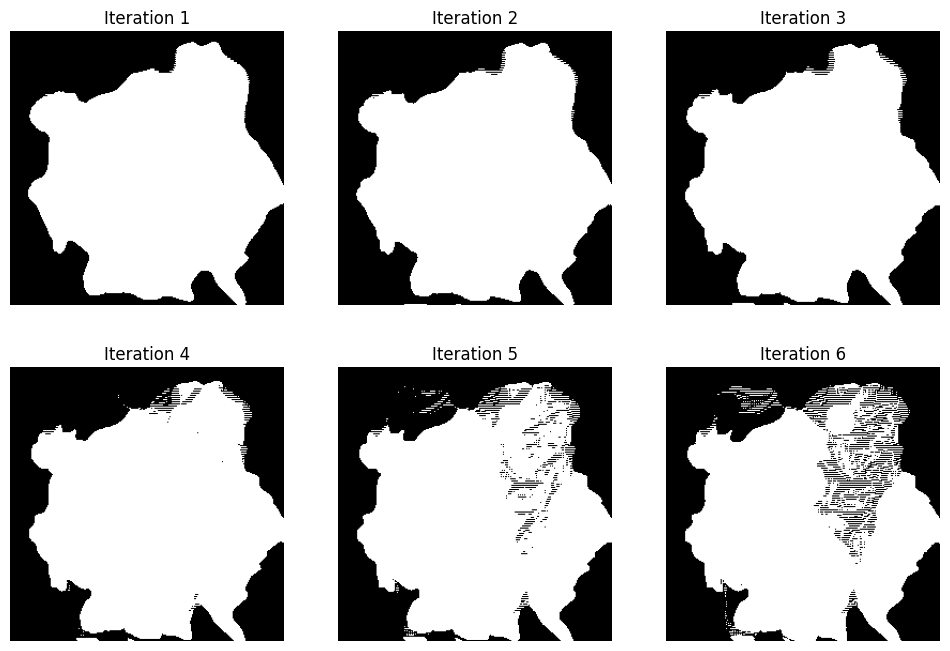

In [58]:
# 2.3. Test simple unet using sample dataset

# Load Train Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_config = simple_unet_config["model"]
simple_unet = smp.Unet(
                  encoder_name    = model_config["encoder_name"],
                  encoder_weights = model_config["encoder_weights"],
                  in_channels     = model_config["in_channels"],
                  classes         = model_config["classes"],
                ).to(device)
simple_unet.load_state_dict(torch.load("simple_unet_with_cspn.pth", map_location=device))

model_config = cspn_unet_config["model"]
cspn_unet = smp.Unet(
                  encoder_name    = model_config["encoder_name"],
                  encoder_weights = model_config["encoder_weights"],
                  in_channels     = model_config["in_channels"],
                  classes         = model_config["classes"],
                ).to(device)
cspn_unet.load_state_dict(torch.load("cspn_unet.pth", map_location=device))

simple_unet.eval()
cspn_unet.eval()

# Load Sample Data
sample = valid_dataloader.dataset[0]
sample_image, sample_mask = sample["image"], sample["mask"]
sample_image, sample_mask = torch.from_numpy(sample_image).float(), torch.from_numpy(sample_mask).float()
sample_image, sample_mask = sample_image.to(device), sample_mask.to(device)

# Foward
sample_image = sample_image.unsqueeze(0)
simple_coarse_segmentation = simple_unet(sample_image)
sample_current_segmentation = simple_unet(sample_image)
sample_affinity = cspn_unet(torch.cat((sample_image, simple_coarse_segmentation), dim=1))
sample_current_segmentation_list = draw_cspn(affinity, sample_current_segmentation , simple_coarse_segmentation)

# Plot
num_iteration = 6
num_per_row = 3

plt.figure(figsize=(12, 8))
for i in range(num_iteration):
    sample_current_segmentation_np = sample_current_segmentation_list[i][0][0]
    sample_current_segmentation_np = sample_current_segmentation_np.sigmoid()
    sample_current_segmentation_np = (sample_current_segmentation_np > 0.5).float()
    sample_current_segmentation_np = sample_current_segmentation_np.detach().cpu().numpy()

    row = i // num_per_row
    col = i % num_per_row
    position = row * num_per_row + col + 1

    plt.subplot(2, num_per_row, position)
    plt.imshow(sample_current_segmentation_np, cmap='gray')
    plt.title(f'Iteration {i + 1}')
    plt.axis('off')

# **Trial of imagenet weight**

In [59]:
# 1. Implementation of any Unet (coarse segmentation)

# 1.1. Load the Unet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_config = simple_unet_config["model"]
simple_unet = smp.Unet(
                  encoder_name    = model_config["encoder_name"],
                  encoder_weights = "imagenet",
                  in_channels     = model_config["in_channels"],
                  classes         = model_config["classes"],
                ).to(device)

# 1.2. Train
train_config = simple_unet_config["train"]
num_epochs = train_config["epoch"]
optimizer = optim.AdamW(simple_unet.parameters(), lr = train_config["lr"])
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

do_simple_unet_train = True
if do_simple_unet_train:
  for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}/{num_epochs}")
      # Train
      simple_unet.train()
      train_loss = 0.0
      train_per_image_iou = 0.0
      train_dataset_iou = 0.0
      for train_images in tqdm(train_dataloader, leave=True):
          # Load Batch Data
          image, mask = train_images["image"], train_images["mask"]
          image, mask = image.float(), mask.float()
          image, mask = image.to(device), mask.to(device)

          # Init Optimizer
          optimizer.zero_grad()

          # Foward
          outputs_mask = simple_unet(image)

          # Backward
          loss = criterion(outputs_mask, mask)
          loss.backward()

          # Sum Train loss
          train_loss += loss.item() * image.size(0)

          # Calculate IOU
          per_image_iou, dataset_iou = cal_iou(outputs_mask, mask)
          train_per_image_iou += per_image_iou
          train_dataset_iou += dataset_iou

          # Update
          optimizer.step()

      # Log one epoch
      train_len = len(train_dataloader)
      train_loss /= train_len
      train_per_image_iou /= train_len
      train_dataset_iou /= train_len
      print(f"Train Loss: {train_loss:.4f}, Train Per Image IOU: {train_per_image_iou:.4f}, Train Dataset IOU: {train_dataset_iou:.4f}")

      # Validation
      simple_unet.eval()
      valid_loss = 0.0
      valid_per_image_iou = 0.0
      valid_dataset_iou = 0.0
      with torch.no_grad():
          for valid_images in tqdm(valid_dataloader, leave=True):
              # Load Batch Data
              image, mask = valid_images["image"], valid_images["mask"]
              image, mask = image.float(), mask.float()
              image, mask = image.to(device), mask.to(device)

              # Prediction
              outputs_mask = simple_unet(image)
              cal_iou(outputs_mask, mask)

              # Loss
              loss = criterion(outputs_mask, mask)

              # Sum Valid loss
              valid_loss += loss.item() * image.size(0)

              # Calculate IOU
              per_image_iou, dataset_iou = cal_iou(outputs_mask, mask)
              valid_per_image_iou += per_image_iou
              valid_dataset_iou += dataset_iou

      # Log one epoch
      valid_len = len(valid_dataloader)
      valid_loss /= valid_len
      valid_per_image_iou /= valid_len
      valid_dataset_iou /= valid_len
      print(f"Valid Loss: {valid_loss:.4f}, Valid Per Image IOU: {valid_per_image_iou:.4f}, Valid Dataset IOU: {valid_dataset_iou:.4f}")

  # Save model
  torch.save(simple_unet.state_dict(), "imagenet_simple_unet.pth")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 133MB/s]


Epoch 1/2


100%|██████████| 414/414 [00:17<00:00, 24.22it/s]


Train Loss: 1.3814, Train Per Image IOU: 0.7236, Train Dataset IOU: 0.7243


100%|██████████| 368/368 [00:05<00:00, 68.97it/s]


Valid Loss: 0.1932, Valid Per Image IOU: 0.6930, Valid Dataset IOU: 0.6930
Epoch 2/2


100%|██████████| 414/414 [00:17<00:00, 24.20it/s]


Train Loss: 1.0093, Train Per Image IOU: 0.7778, Train Dataset IOU: 0.7785


100%|██████████| 368/368 [00:05<00:00, 72.22it/s]


Valid Loss: 0.1590, Valid Per Image IOU: 0.7412, Valid Dataset IOU: 0.7412


(-0.5, 255.5, 255.5, -0.5)

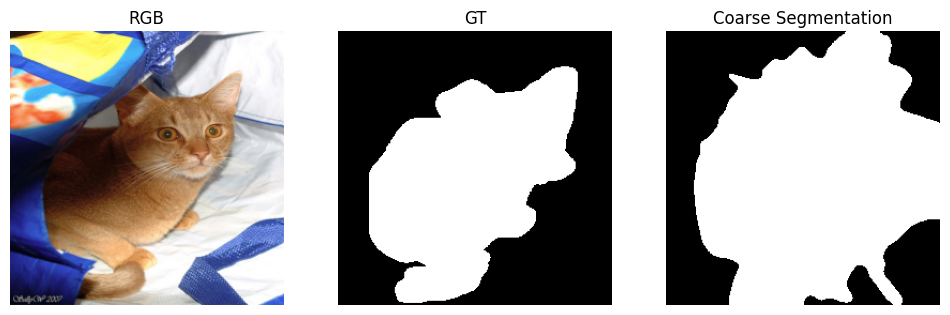

In [60]:
# 1.3. Test simple unet using sample dataset

# Load Train Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_config = simple_unet_config["model"]
simple_unet = smp.Unet(
                  encoder_name    = model_config["encoder_name"],
                  encoder_weights = "imagenet",
                  in_channels     = model_config["in_channels"],
                  classes         = model_config["classes"],
                ).to(device)
simple_unet.load_state_dict(torch.load("imagenet_simple_unet.pth", map_location=device))

simple_unet.eval()

# Load Sample Data
sample = valid_dataloader.dataset[0]
sample_image, sample_mask = sample["image"], sample["mask"]
sample_image, sample_mask = torch.from_numpy(sample_image).float(), torch.from_numpy(sample_mask).float()
sample_image, sample_mask = sample_image.to(device), sample_mask.to(device)

# Foward
sample_image = sample_image.unsqueeze(0)
sample_outputs_mask = simple_unet(sample_image)

# Plot
sample_image_np = sample["image"]
sample_image_np = np.transpose(sample_image_np, (1, 2, 0))

sample_mask_np = sample["mask"][0]

sample_outputs_mask_np = sample_outputs_mask[0][0]
sample_outputs_mask_np = sample_outputs_mask_np.sigmoid()
sample_outputs_mask_np = (sample_outputs_mask_np > 0.5).float()
sample_outputs_mask_np = sample_outputs_mask_np.cpu().detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sample_image_np)
plt.title('RGB')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask_np, cmap='gray')
plt.title('GT')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sample_outputs_mask_np, cmap='gray')
plt.title('Coarse Segmentation')
plt.axis('off')

In [61]:
def cspn(affinity, current_segmentation, coarse_segmentation):
    # CSPN Const
    iterations = 6
    kernel_size = 3
    padding = 1
    stride = 1

    # Input Const
    batch_size, channel, height, width = current_segmentation.size()

    # 2.a. Get an affinity that sums to 1
    affinity = F.normalize(affinity, p=1, dim=1)

    # Calculate center affinitty
    center_affinity = 1 - affinity.sum(dim=1, keepdim=True)

    # Concat
    affinity = torch.cat([affinity[:, :4, :, :], center_affinity, affinity[:, 4:, :, :]], dim=1)
    affinity = affinity.view(batch_size, 9, height * width)

    # 2.c. Iteratively refine the segmentation
    for i in range(iterations):
        # Unfold current segmentation
        current_segmentation_unfold = F.unfold(current_segmentation, kernel_size=kernel_size, padding=padding, stride=stride)
        current_segmentation_unfold = current_segmentation_unfold.view(batch_size, 9, height * width)
        current_segmentation_unfold[:, 4, :] = current_segmentation.view(batch_size, height * width)

        # 2.b. The segmetnation map multiplied by the affinity of the correct position.
        # Multiply affinity and current_segmentation_unfold
        output = current_segmentation_unfold * affinity
        output = output.sum(dim=1)

        # Update current segmentation
        current_segmentation = output.view(batch_size, channel, height, width)

    return current_segmentation

In [62]:
# 2. Implementation of CSPN (refined segmentation)

# 2.1. Load the Unet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_config = cspn_unet_config["model"]
cspn_unet = smp.Unet(
                  encoder_name    = model_config["encoder_name"],
                  encoder_weights = "imagenet",
                  in_channels     = model_config["in_channels"],
                  classes         = model_config["classes"],
                ).to(device)

# 2.2. Train
train_config = cspn_unet_config["train"]
num_epochs = train_config["epoch"]
optimizer = optim.AdamW(cspn_unet.parameters(), lr = train_config["lr"])
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

do_cspn_unet_train = True
if do_cspn_unet_train:
  for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}/{num_epochs}")
      # Train
      cspn_unet.train()
      simple_unet.train()
      train_loss = 0.0
      train_per_image_iou = 0.0
      train_dataset_iou = 0.0
      for train_images in tqdm(train_dataloader, leave=True):
          # Load Batch Data
          image, mask = train_images["image"], train_images["mask"]
          image, mask = image.float(), mask.float()
          image, mask = image.to(device), mask.to(device)

          # Init Optimizer
          optimizer.zero_grad()

          # Foward
          coarse_segmentation = simple_unet(image)
          current_segmentation = simple_unet(image)
          affinity = cspn_unet(torch.cat((image, coarse_segmentation), dim=1))
          current_segmentation = cspn(affinity, current_segmentation, coarse_segmentation)

          # Backward

          loss = criterion(current_segmentation, mask)
          loss.backward()

          # Sum Train loss
          train_loss += loss.item() * image.size(0)

          # Calculate IOU
          per_image_iou, dataset_iou = cal_iou(current_segmentation, mask)
          train_per_image_iou += per_image_iou
          train_dataset_iou += dataset_iou

          # Update
          optimizer.step()

      # Log one epoch
      train_len = len(train_dataloader)
      train_loss /= train_len
      train_per_image_iou /= train_len
      train_dataset_iou /= train_len
      print(f"Train Loss: {train_loss:.4f}, Train Per Image IOU: {train_per_image_iou:.4f}, Train Dataset IOU: {train_dataset_iou:.4f}")

      # Validation
      cspn_unet.eval()
      simple_unet.eval()
      valid_loss = 0.0
      valid_per_image_iou = 0.0
      valid_dataset_iou = 0.0
      with torch.no_grad():
          for valid_images in tqdm(valid_dataloader, leave=True):
              # Load Batch Data
              image, mask = valid_images["image"], valid_images["mask"]
              image, mask = image.float(), mask.float()
              image, mask = image.to(device), mask.to(device)

              # Prediction
              coarse_segmentation = simple_unet(image)
              current_segmentation = simple_unet(image)
              affinity = cspn_unet(torch.cat((image, coarse_segmentation), dim=1))
              current_segmentation = cspn(affinity, current_segmentation, coarse_segmentation)

              # Loss
              loss = criterion(current_segmentation, mask)

              # Sum Valid loss
              valid_loss += loss.item() * image.size(0)

              # Calculate IOU
              per_image_iou, dataset_iou = cal_iou(current_segmentation, mask)
              valid_per_image_iou += per_image_iou
              valid_dataset_iou += dataset_iou

      # Log one epoch
      valid_len = len(valid_dataloader)
      valid_loss /= valid_len
      valid_per_image_iou /= valid_len
      valid_dataset_iou /= valid_len
      print(f"Valid Loss: {valid_loss:.4f}, Valid Per Image IOU: {valid_per_image_iou:.4f}, Valid Dataset IOU: {valid_dataset_iou:.4f}")


Epoch 1/40


100%|██████████| 414/414 [00:38<00:00, 10.63it/s]


Train Loss: 0.9369, Train Per Image IOU: 0.7902, Train Dataset IOU: 0.7927


100%|██████████| 368/368 [00:10<00:00, 33.67it/s]


Valid Loss: 0.1226, Valid Per Image IOU: 0.7925, Valid Dataset IOU: 0.7925
Epoch 2/40


100%|██████████| 414/414 [00:38<00:00, 10.67it/s]


Train Loss: 0.9377, Train Per Image IOU: 0.7905, Train Dataset IOU: 0.7925


100%|██████████| 368/368 [00:10<00:00, 34.32it/s]


Valid Loss: 0.1253, Valid Per Image IOU: 0.7885, Valid Dataset IOU: 0.7885
Epoch 3/40


100%|██████████| 414/414 [00:39<00:00, 10.61it/s]


Train Loss: 0.9287, Train Per Image IOU: 0.7919, Train Dataset IOU: 0.7940


100%|██████████| 368/368 [00:10<00:00, 34.45it/s]


Valid Loss: 0.1216, Valid Per Image IOU: 0.7938, Valid Dataset IOU: 0.7938
Epoch 4/40


100%|██████████| 414/414 [00:38<00:00, 10.62it/s]


Train Loss: 0.9378, Train Per Image IOU: 0.7920, Train Dataset IOU: 0.7924


100%|██████████| 368/368 [00:10<00:00, 34.50it/s]


Valid Loss: 0.1209, Valid Per Image IOU: 0.7944, Valid Dataset IOU: 0.7944
Epoch 5/40


100%|██████████| 414/414 [00:39<00:00, 10.59it/s]


Train Loss: 0.9158, Train Per Image IOU: 0.7942, Train Dataset IOU: 0.7965


100%|██████████| 368/368 [00:10<00:00, 33.76it/s]


Valid Loss: 0.1237, Valid Per Image IOU: 0.7909, Valid Dataset IOU: 0.7909
Epoch 6/40


100%|██████████| 414/414 [00:39<00:00, 10.54it/s]


Train Loss: 0.9045, Train Per Image IOU: 0.7970, Train Dataset IOU: 0.7988


100%|██████████| 368/368 [00:10<00:00, 34.05it/s]


Valid Loss: 0.1190, Valid Per Image IOU: 0.7977, Valid Dataset IOU: 0.7977
Epoch 7/40


100%|██████████| 414/414 [00:38<00:00, 10.62it/s]


Train Loss: 0.9030, Train Per Image IOU: 0.7983, Train Dataset IOU: 0.7991


100%|██████████| 368/368 [00:10<00:00, 34.10it/s]


Valid Loss: 0.1197, Valid Per Image IOU: 0.7967, Valid Dataset IOU: 0.7967
Epoch 8/40


100%|██████████| 414/414 [00:39<00:00, 10.59it/s]


Train Loss: 0.8843, Train Per Image IOU: 0.8014, Train Dataset IOU: 0.8030


100%|██████████| 368/368 [00:10<00:00, 34.13it/s]


Valid Loss: 0.1175, Valid Per Image IOU: 0.8004, Valid Dataset IOU: 0.8004
Epoch 9/40


100%|██████████| 414/414 [00:38<00:00, 10.62it/s]


Train Loss: 0.8883, Train Per Image IOU: 0.8007, Train Dataset IOU: 0.8022


100%|██████████| 368/368 [00:10<00:00, 33.82it/s]


Valid Loss: 0.1157, Valid Per Image IOU: 0.8030, Valid Dataset IOU: 0.8030
Epoch 10/40


100%|██████████| 414/414 [00:38<00:00, 10.63it/s]


Train Loss: 0.8795, Train Per Image IOU: 0.8030, Train Dataset IOU: 0.8040


100%|██████████| 368/368 [00:10<00:00, 34.04it/s]


Valid Loss: 0.1226, Valid Per Image IOU: 0.7925, Valid Dataset IOU: 0.7925
Epoch 11/40


100%|██████████| 414/414 [00:38<00:00, 10.62it/s]


Train Loss: 0.8660, Train Per Image IOU: 0.8053, Train Dataset IOU: 0.8067


100%|██████████| 368/368 [00:10<00:00, 33.75it/s]


Valid Loss: 0.1194, Valid Per Image IOU: 0.7976, Valid Dataset IOU: 0.7976
Epoch 12/40


100%|██████████| 414/414 [00:38<00:00, 10.67it/s]


Train Loss: 0.8658, Train Per Image IOU: 0.8051, Train Dataset IOU: 0.8067


100%|██████████| 368/368 [00:10<00:00, 34.36it/s]


Valid Loss: 0.1169, Valid Per Image IOU: 0.8013, Valid Dataset IOU: 0.8013
Epoch 13/40


100%|██████████| 414/414 [00:38<00:00, 10.62it/s]


Train Loss: 0.8651, Train Per Image IOU: 0.8066, Train Dataset IOU: 0.8068


100%|██████████| 368/368 [00:11<00:00, 33.32it/s]


Valid Loss: 0.1197, Valid Per Image IOU: 0.7965, Valid Dataset IOU: 0.7965
Epoch 14/40


100%|██████████| 414/414 [00:38<00:00, 10.69it/s]


Train Loss: 0.8520, Train Per Image IOU: 0.8078, Train Dataset IOU: 0.8095


100%|██████████| 368/368 [00:10<00:00, 34.03it/s]


Valid Loss: 0.1157, Valid Per Image IOU: 0.8024, Valid Dataset IOU: 0.8024
Epoch 15/40


100%|██████████| 414/414 [00:38<00:00, 10.62it/s]


Train Loss: 0.8380, Train Per Image IOU: 0.8110, Train Dataset IOU: 0.8123


100%|██████████| 368/368 [00:10<00:00, 34.69it/s]


Valid Loss: 0.1206, Valid Per Image IOU: 0.7961, Valid Dataset IOU: 0.7961
Epoch 16/40


100%|██████████| 414/414 [00:38<00:00, 10.62it/s]


Train Loss: 0.8346, Train Per Image IOU: 0.8111, Train Dataset IOU: 0.8131


100%|██████████| 368/368 [00:10<00:00, 33.49it/s]


Valid Loss: 0.1175, Valid Per Image IOU: 0.8006, Valid Dataset IOU: 0.8006
Epoch 17/40


100%|██████████| 414/414 [00:39<00:00, 10.61it/s]


Train Loss: 0.8300, Train Per Image IOU: 0.8120, Train Dataset IOU: 0.8139


100%|██████████| 368/368 [00:10<00:00, 34.18it/s]


Valid Loss: 0.1120, Valid Per Image IOU: 0.8080, Valid Dataset IOU: 0.8080
Epoch 18/40


100%|██████████| 414/414 [00:39<00:00, 10.60it/s]


Train Loss: 0.8275, Train Per Image IOU: 0.8125, Train Dataset IOU: 0.8144


100%|██████████| 368/368 [00:10<00:00, 34.37it/s]


Valid Loss: 0.1103, Valid Per Image IOU: 0.8104, Valid Dataset IOU: 0.8104
Epoch 19/40


100%|██████████| 414/414 [00:39<00:00, 10.59it/s]


Train Loss: 0.8127, Train Per Image IOU: 0.8156, Train Dataset IOU: 0.8172


100%|██████████| 368/368 [00:10<00:00, 33.63it/s]


Valid Loss: 0.1126, Valid Per Image IOU: 0.8080, Valid Dataset IOU: 0.8080
Epoch 20/40


100%|██████████| 414/414 [00:39<00:00, 10.59it/s]


Train Loss: 0.8164, Train Per Image IOU: 0.8157, Train Dataset IOU: 0.8168


100%|██████████| 368/368 [00:10<00:00, 34.05it/s]


Valid Loss: 0.1122, Valid Per Image IOU: 0.8080, Valid Dataset IOU: 0.8080
Epoch 21/40


100%|██████████| 414/414 [00:38<00:00, 10.63it/s]


Train Loss: 0.8033, Train Per Image IOU: 0.8166, Train Dataset IOU: 0.8191


100%|██████████| 368/368 [00:10<00:00, 33.85it/s]


Valid Loss: 0.1118, Valid Per Image IOU: 0.8092, Valid Dataset IOU: 0.8092
Epoch 22/40


100%|██████████| 414/414 [00:38<00:00, 10.68it/s]


Train Loss: 0.7993, Train Per Image IOU: 0.8175, Train Dataset IOU: 0.8201


100%|██████████| 368/368 [00:11<00:00, 33.39it/s]


Valid Loss: 0.1112, Valid Per Image IOU: 0.8096, Valid Dataset IOU: 0.8096
Epoch 23/40


100%|██████████| 414/414 [00:39<00:00, 10.58it/s]


Train Loss: 0.7971, Train Per Image IOU: 0.8181, Train Dataset IOU: 0.8206


100%|██████████| 368/368 [00:10<00:00, 34.33it/s]


Valid Loss: 0.1083, Valid Per Image IOU: 0.8138, Valid Dataset IOU: 0.8138
Epoch 24/40


100%|██████████| 414/414 [00:38<00:00, 10.68it/s]


Train Loss: 0.7965, Train Per Image IOU: 0.8188, Train Dataset IOU: 0.8208


100%|██████████| 368/368 [00:10<00:00, 33.97it/s]


Valid Loss: 0.1086, Valid Per Image IOU: 0.8139, Valid Dataset IOU: 0.8139
Epoch 25/40


100%|██████████| 414/414 [00:38<00:00, 10.65it/s]


Train Loss: 0.7964, Train Per Image IOU: 0.8193, Train Dataset IOU: 0.8209


100%|██████████| 368/368 [00:10<00:00, 33.94it/s]


Valid Loss: 0.1129, Valid Per Image IOU: 0.8076, Valid Dataset IOU: 0.8076
Epoch 26/40


100%|██████████| 414/414 [00:39<00:00, 10.58it/s]


Train Loss: 0.7938, Train Per Image IOU: 0.8203, Train Dataset IOU: 0.8215


100%|██████████| 368/368 [00:10<00:00, 34.07it/s]


Valid Loss: 0.1059, Valid Per Image IOU: 0.8174, Valid Dataset IOU: 0.8174
Epoch 27/40


100%|██████████| 414/414 [00:39<00:00, 10.58it/s]


Train Loss: 0.7819, Train Per Image IOU: 0.8220, Train Dataset IOU: 0.8239


100%|██████████| 368/368 [00:10<00:00, 34.31it/s]


Valid Loss: 0.1104, Valid Per Image IOU: 0.8105, Valid Dataset IOU: 0.8105
Epoch 28/40


100%|██████████| 414/414 [00:39<00:00, 10.53it/s]


Train Loss: 0.7674, Train Per Image IOU: 0.8236, Train Dataset IOU: 0.8267


100%|██████████| 368/368 [00:10<00:00, 34.01it/s]


Valid Loss: 0.1104, Valid Per Image IOU: 0.8105, Valid Dataset IOU: 0.8105
Epoch 29/40


100%|██████████| 414/414 [00:39<00:00, 10.51it/s]


Train Loss: 0.7781, Train Per Image IOU: 0.8230, Train Dataset IOU: 0.8247


100%|██████████| 368/368 [00:10<00:00, 33.57it/s]


Valid Loss: 0.1103, Valid Per Image IOU: 0.8110, Valid Dataset IOU: 0.8110
Epoch 30/40


100%|██████████| 414/414 [00:38<00:00, 10.64it/s]


Train Loss: 0.7784, Train Per Image IOU: 0.8225, Train Dataset IOU: 0.8243


100%|██████████| 368/368 [00:10<00:00, 33.63it/s]


Valid Loss: 0.1071, Valid Per Image IOU: 0.8158, Valid Dataset IOU: 0.8158
Epoch 31/40


100%|██████████| 414/414 [00:39<00:00, 10.58it/s]


Train Loss: 0.7548, Train Per Image IOU: 0.8262, Train Dataset IOU: 0.8292


100%|██████████| 368/368 [00:10<00:00, 34.09it/s]


Valid Loss: 0.1068, Valid Per Image IOU: 0.8160, Valid Dataset IOU: 0.8160
Epoch 32/40


100%|██████████| 414/414 [00:39<00:00, 10.58it/s]


Train Loss: 0.7682, Train Per Image IOU: 0.8245, Train Dataset IOU: 0.8266


100%|██████████| 368/368 [00:10<00:00, 34.37it/s]


Valid Loss: 0.1043, Valid Per Image IOU: 0.8202, Valid Dataset IOU: 0.8202
Epoch 33/40


100%|██████████| 414/414 [00:39<00:00, 10.57it/s]


Train Loss: 0.7651, Train Per Image IOU: 0.8262, Train Dataset IOU: 0.8275


100%|██████████| 368/368 [00:10<00:00, 33.73it/s]


Valid Loss: 0.1103, Valid Per Image IOU: 0.8111, Valid Dataset IOU: 0.8111
Epoch 34/40


100%|██████████| 414/414 [00:39<00:00, 10.52it/s]


Train Loss: 0.7463, Train Per Image IOU: 0.8280, Train Dataset IOU: 0.8310


100%|██████████| 368/368 [00:10<00:00, 34.33it/s]


Valid Loss: 0.1113, Valid Per Image IOU: 0.8100, Valid Dataset IOU: 0.8100
Epoch 35/40


100%|██████████| 414/414 [00:39<00:00, 10.59it/s]


Train Loss: 0.7477, Train Per Image IOU: 0.8279, Train Dataset IOU: 0.8308


100%|██████████| 368/368 [00:11<00:00, 33.44it/s]


Valid Loss: 0.1070, Valid Per Image IOU: 0.8160, Valid Dataset IOU: 0.8160
Epoch 36/40


100%|██████████| 414/414 [00:38<00:00, 10.68it/s]


Train Loss: 0.7522, Train Per Image IOU: 0.8279, Train Dataset IOU: 0.8300


100%|██████████| 368/368 [00:10<00:00, 33.85it/s]


Valid Loss: 0.1105, Valid Per Image IOU: 0.8117, Valid Dataset IOU: 0.8117
Epoch 37/40


100%|██████████| 414/414 [00:39<00:00, 10.59it/s]


Train Loss: 0.7368, Train Per Image IOU: 0.8304, Train Dataset IOU: 0.8332


100%|██████████| 368/368 [00:10<00:00, 33.93it/s]


Valid Loss: 0.1072, Valid Per Image IOU: 0.8163, Valid Dataset IOU: 0.8163
Epoch 38/40


100%|██████████| 414/414 [00:39<00:00, 10.51it/s]


Train Loss: 0.7353, Train Per Image IOU: 0.8308, Train Dataset IOU: 0.8334


100%|██████████| 368/368 [00:11<00:00, 33.42it/s]


Valid Loss: 0.1042, Valid Per Image IOU: 0.8204, Valid Dataset IOU: 0.8204
Epoch 39/40


100%|██████████| 414/414 [00:39<00:00, 10.56it/s]


Train Loss: 0.7364, Train Per Image IOU: 0.8301, Train Dataset IOU: 0.8332


100%|██████████| 368/368 [00:10<00:00, 33.77it/s]


Valid Loss: 0.1029, Valid Per Image IOU: 0.8227, Valid Dataset IOU: 0.8227
Epoch 40/40


100%|██████████| 414/414 [00:39<00:00, 10.53it/s]


Train Loss: 0.7384, Train Per Image IOU: 0.8291, Train Dataset IOU: 0.8326


100%|██████████| 368/368 [00:10<00:00, 33.99it/s]

Valid Loss: 0.1021, Valid Per Image IOU: 0.8237, Valid Dataset IOU: 0.8237


In [63]:
torch.save(cspn_unet.state_dict(), "imagenet_cspn_unet.pth")
torch.save(simple_unet.state_dict(), "imagenet_simple_unet_with_cspn.pth")

In [64]:
def draw_cspn(affinity, current_segmentation, coarse_segmentation):
    # CSPN Const
    iterations = 6
    kernel_size = 3
    padding = 1
    stride = 1

    # Input Const
    batch_size, channel, height, width = current_segmentation.size()

    # 2.a. Get an affinity that sums to 1
    # Nomalize the affinity
    affinity = F.normalize(affinity, p=1, dim=1)

    # Calculate center affinitty
    center_affinity = 1 - affinity.sum(dim=1, keepdim=True)


    # Concat
    affinity = torch.cat([affinity[:, :4, :, :], center_affinity, affinity[:, 4:, :, :]], dim=1)
    affinity = affinity.view(batch_size, 9, height * width)

    current_segmentation_list = []
    # 2.c. Iteratively refine the segmentation
    for i in range(iterations):
        # Unfold current segmentation
        current_segmentation_unfold = F.unfold(current_segmentation, kernel_size=kernel_size, padding=padding, stride=stride)
        current_segmentation_unfold = current_segmentation_unfold.view(batch_size, 9, height * width)
        current_segmentation_unfold[:, 4, :] = current_segmentation.view(batch_size, height * width)

        # 2.b. The segmetnation map multiplied by the affinity of the correct position.
        # Multiply affinity and current_segmentation_unfold
        output = current_segmentation_unfold * affinity
        output = output.sum(dim=1)

        # Update current segmentation
        current_segmentation = output.view(batch_size, channel, height, width)
        current_segmentation_list.append(current_segmentation)

    return current_segmentation_list

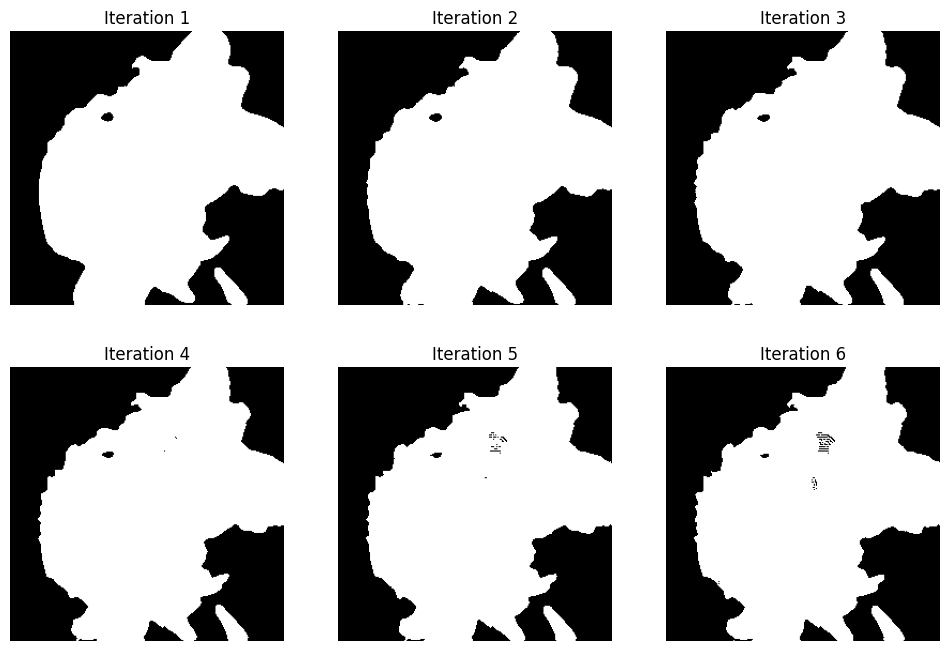

In [65]:
# 2.3. Test simple unet using sample dataset

# Load Train Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_config = simple_unet_config["model"]
simple_unet = smp.Unet(
                  encoder_name    = model_config["encoder_name"],
                  encoder_weights = model_config["encoder_weights"],
                  in_channels     = model_config["in_channels"],
                  classes         = model_config["classes"],
                ).to(device)
simple_unet.load_state_dict(torch.load("imagenet_simple_unet_with_cspn.pth", map_location=device))

model_config = cspn_unet_config["model"]
cspn_unet = smp.Unet(
                  encoder_name    = model_config["encoder_name"],
                  encoder_weights = model_config["encoder_weights"],
                  in_channels     = model_config["in_channels"],
                  classes         = model_config["classes"],
                ).to(device)
cspn_unet.load_state_dict(torch.load("imagenet_cspn_unet.pth", map_location=device))

simple_unet.eval()
cspn_unet.eval()

# Load Sample Data
sample = valid_dataloader.dataset[0]
sample_image, sample_mask = sample["image"], sample["mask"]
sample_image, sample_mask = torch.from_numpy(sample_image).float(), torch.from_numpy(sample_mask).float()
sample_image, sample_mask = sample_image.to(device), sample_mask.to(device)

# Foward
sample_image = sample_image.unsqueeze(0)
simple_coarse_segmentation = simple_unet(sample_image)
sample_current_segmentation = simple_unet(sample_image)
sample_affinity = cspn_unet(torch.cat((sample_image, simple_coarse_segmentation), dim=1))
sample_current_segmentation_list = draw_cspn(affinity, sample_current_segmentation , simple_coarse_segmentation)

# Plot
num_iteration = 6
num_per_row = 3

plt.figure(figsize=(12, 8))
for i in range(num_iteration):
    sample_current_segmentation_np = sample_current_segmentation_list[i][0][0]
    sample_current_segmentation_np = sample_current_segmentation_np.sigmoid()
    sample_current_segmentation_np = (sample_current_segmentation_np > 0.5).float()
    sample_current_segmentation_np = sample_current_segmentation_np.detach().cpu().numpy()

    row = i // num_per_row
    col = i % num_per_row
    position = row * num_per_row + col + 1

    plt.subplot(2, num_per_row, position)
    plt.imshow(sample_current_segmentation_np, cmap='gray')
    plt.title(f'Iteration {i + 1}')
    plt.axis('off')